# `xvr` tutorial

1. Connect to a GPU: `Runtime > Change runtime type > T4 GPU`
2. Install `xvr`
3. Download data and pretrained models

In [1]:
!pip install git+https://github.com/eigenvivek/xvr.git --upgrade

  Cloning https://github.com/eigenvivek/xvr.git to /tmp/pip-req-build-pxac9tru
  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/xvr.git /tmp/pip-req-build-pxac9tru
  Resolved https://github.com/eigenvivek/xvr.git to commit af8287cd6d8cf0bad4cb07d746a5fff7b1eeaecb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [2]:
!pip install git+https://github.com/eigenvivek/DiffDRR.git

!pip install nibabel pydicom matplotlib tqdm


  Cloning https://github.com/eigenvivek/DiffDRR.git to /tmp/pip-req-build-p3j5vptv
  Running command git clone --filter=blob:none --quiet https://github.com/eigenvivek/DiffDRR.git /tmp/pip-req-build-p3j5vptv
  Resolved https://github.com/eigenvivek/DiffDRR.git to commit acaa68c9de88f50e9ac0e7adf34a68b769cf4368
  Preparing metadata (setup.py) ... done
  Created wheel for diffdrr: filename=diffdrr-0.6.0rc1-py3-none-any.whl size=34802890 sha256=3dd3207540513080d68819bc9c40fb30912278c018b43748ca3556f940587cd1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ok3l18qw/wheels/70/73/7f/378dd03aa4bd2a4c42c4a652028a9a01dcff775face2ac4a2b
Successfully built diffdrr
  Attempting uninstall: diffdrr
    Found existing installation: diffdrr 0.5.1
    Uninstalling diffdrr-0.5.1:
      Successfully uninstalled diffdrr-0.5.1


## Install `xvr`

In [3]:
!xvr --version

xvr, version 0.0.0rc1


## Test-time optimization

Here, we show how to iteratively refine the initial poses estimated by a patient-specific neural network.

In [4]:
!HF_HUB_DISABLE_PROGRESS_BARS=TRUE

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffdrr.pose import RigidTransform
from huggingface_hub import snapshot_download

from xvr.metrics import Evaluator
from xvr.registrar import RegistrarModel
from xvr.utils import XrayTransforms
from xvr.visualization import plot_registration

In [7]:
import matplotlib.pyplot as plt
import torch
from diffdrr.visualization import plot_drr
from xvr.metrics import Evaluator
from xvr.utils import XrayTransforms
from diffdrr.pose import RigidTransform

def plot_registration(drr, fiducials, gt, pred_pose, true_pose):
    """
    Visualize registration results:
    - Uses unflipped pred_pose for DRR rendering (ensures valid image)
    - Uses flipped pred_pose for fiducial projection and mTRE calculation (ensures alignment)
    """
    # Step 1: Flip a copy of the predicted pose for fiducial projection & evaluation
    flipped_pose = RigidTransform(matrix=pred_pose.matrix.clone())
    # flipped_pose.matrix[0, 0, 3] *= -1  # Flip X translation
    flipped_pose.matrix[0, 1, 3] *= -1  # Flip Y translation
    # flipped_pose.matrix[0, 2, 3] *= -1  # Flip Z translation


    # Step 2: Evaluate mTRE using pose
    evaluator = Evaluator(drr, fiducials)
    mtre = evaluator(true_pose, flipped_pose)[2]

    # Step 3: Generate DRRs and project fiducials
    with torch.no_grad():
        pred_img = drr(pred_pose).cpu()
        true_img = drr(true_pose).cpu()
        error = (true_img - pred_img)

        pred_pts = drr.perspective_projection(flipped_pose, fiducials).cpu().squeeze()
        true_pts = drr.perspective_projection(true_pose, fiducials).cpu().squeeze()

    xt = XrayTransforms(drr.detector.height, drr.detector.width)
    gt = xt(gt)
    pred_img = xt(pred_img)

    axs = plot_drr(torch.concat([pred_img, gt, error]))

    axs[1].scatter(true_pts[..., 0], true_pts[..., 1], color="dodgerblue", label="True")
    axs[1].scatter(pred_pts[..., 0], pred_pts[..., 1], color="darkorange", label="Pred")
    for x, y in zip(pred_pts, true_pts):
        axs[1].plot([x[0], y[0]], [x[1], y[1]], "w--", linewidth=0.8)
    axs[1].legend()

    plot_drr(
        torch.concat([pred_img, gt, error]),
        title=[
            "DRR from Predicted Pose",
            "Ground truth X-ray",
            f"Error (mTRE = {mtre:.2f} mm)"
        ],
        ticks=False,
        axs=axs,
    )

    axs[2].imshow(
        error[0].permute(1, 2, 0),
        cmap="bwr",
        vmin=-error.abs().max(),
        vmax=error.abs().max()
    )

    plt.tight_layout()
    plt.show()


## Evaluating pretrained models

Here, we are using the pretrained models and testing them using our Femur CT data and x ray image to find the pose value.

In [8]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

#Model Evaluation

In [9]:
true_pose = torch.load("/content/128x128 prox pose.pt", weights_only=False).cuda()

print("True Pose:",true_pose.matrix)

True Pose: tensor([[[  1.,   0.,   0.,   0.],
         [  0.,   1.,   0., 550.],
         [  0.,   0.,   1., 170.],
         [  0.,   0.,   0.,   1.]]], device='cuda:0')


In [10]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    """
    Converts a 4x4 homogeneous pose matrix to Euler angles and translation vector.

    Args:
        pose_matrix (torch.Tensor): shape [4, 4] or [1, 4, 4]
        convention (str): e.g., "ZXY"
        degrees (bool): Return angles in degrees (True) or radians (False)

    Returns:
        euler_angles (torch.Tensor): shape [3] (rx, ry, rz)
        translation (torch.Tensor): shape [3] (x, y, z)
    """
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(true_pose.matrix, convention="ZXY", degrees=True)
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Rotation angles (ZXY) in degrees: tensor([0., 0., 0.])
Translation (mm): tensor([  0., 550., 170.])


In [11]:
# Load the ground truth 3D fiducials
fiducials = torch.load("/content/128x128 prox fiducials.pt", weights_only=False).cuda()
# fiducials = fiducials.unsqueeze(0)  # Adds a batch dimension at dim=0

In [12]:
print("Fiducials",fiducials)

Fiducials tensor([[[ -21.8499, -470.0000,  206.0735],
         [ -17.4252, -470.0000,  238.4072],
         [ -57.2468, -470.0000,  172.3783],
         [  -8.2357, -470.0000,  127.1111],
         [  14.5681, -470.0000,  155.0202],
         [   1.9750, -470.0000,  181.2275],
         [  45.5404, -470.0000,  157.4027],
         [  48.9440, -470.0000,  182.5890],
         [  25.7998, -470.0000,  227.1755],
         [  20.0138, -470.0000,  266.3163],
         [  16.9506, -470.0000,  294.2254],
         [  -7.2146, -470.0000,  263.5934],
         [  -5.5128, -470.0000,  301.3729],
         [ -29.3377, -470.0000,  221.0491],
         [ -66.7767, -470.0000,  126.7707],
         [ -36.4851, -470.0000,  142.4271],
         [ -28.9973, -470.0000,  177.8240],
         [  -4.1514, -470.0000,  139.7042]]], device='cuda:0')


Dataset.file_meta -------------------------------
(0002,0002) Media Storage SOP Class UID         UI: X-Ray Angiographic Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.72064230809901869038757861996543397670
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008,0016) SOP Class UID                       UI: X-Ray Angiographic Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.72064230809901869038757861996543397670
(0008,0020) Study Date                          DA: '20250626'
(0008,0030) Study Time                          TM: '135045'
(0008,0060) Modality                            CS: 'OT'
(0010,0010) Patient's Name                      PN: 'Synthetic'
(0010,0020) Patient ID   

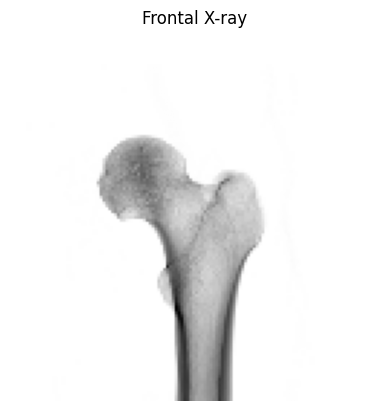

In [13]:
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path

dicom_img = pydicom.dcmread("/content/128x128 prox.dcm")

# Print metadata
print(dicom_img)

# Display the image
plt.imshow(dicom_img.pixel_array, cmap='gray')
plt.title("Frontal X-ray")
plt.axis('off')
plt.show()


In [14]:
model_agnostic = RegistrarModel(
        volume="/content/drive/MyDrive/Robossis-Akshat-Sharan/RXVR-1.0/RXVR-1.0 DO_Report Files/SE000002.nii.gz",
        mask=None,
        # ckptpath="trained-new-paths/finetuned02_10ep.pth",
        # ckptpath = "/content/drive/MyDrive/Trained Registration model/Finetuned/Agnostic Fine tuned Default Parameter/xvr_0005.pth", # Best for full bone
        ckptpath = "/content/drive/MyDrive/Robossis-Akshat-Sharan/RXVR1.1_best.pth",
        crop=0,
        init_only=False,
    )

In [15]:
# Demonstrate the patient-agnostic model
gt, _, drr, init_pose, final_pose, _ = model_agnostic.run("/content/128x128 prox.dcm", beta=0.5)


Stage 1:   5%|██                                      | 25/500 [00:01<00:20, 22.65it/s, ncc = 0.259]


In [16]:
print("Initial Pose:",init_pose.matrix)
print(type(init_pose))

Initial Pose: tensor([[[ 8.8001e-01,  4.6146e-01,  1.1246e-01, -2.0867e+02],
         [-4.6858e-01,  8.8217e-01,  4.6870e-02, -4.0781e+02],
         [-7.7579e-02, -9.3941e-02,  9.9255e-01,  1.8073e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')
<class 'diffdrr.pose.RigidTransform'>


In [17]:
print("Final Pose:",final_pose.matrix)
print(type(final_pose))

Final Pose: tensor([[[ 8.7552e-01,  4.7494e-01,  8.8833e-02, -2.1779e+02],
         [-4.8227e-01,  8.7023e-01,  1.0054e-01, -3.8837e+02],
         [-2.9556e-02, -1.3087e-01,  9.9096e-01,  1.9520e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<CopySlices>)
<class 'diffdrr.pose.RigidTransform'>


In [18]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].cpu().numpy()
    t_vec = pose_matrix[:3, 3].cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(init_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Initial Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Initial Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([-27.9759,  -2.6864,   6.4641])
Translation (mm): tensor([-208.6660, -407.8084,  180.7286])


In [19]:
from scipy.spatial.transform import Rotation as Rsc

def matrix_to_euler_and_translation(pose_matrix: torch.Tensor, convention="ZXY", degrees=True):
    if pose_matrix.ndim == 3:
        pose_matrix = pose_matrix.squeeze(0)

    # Extract rotation and translation
    R_mat = pose_matrix[:3, :3].detach().cpu().numpy()
    t_vec = pose_matrix[:3, 3].detach().cpu()

    # Convert rotation matrix to Euler angles
    rot = Rsc.from_matrix(R_mat)
    angles = rot.as_euler(convention.lower(), degrees=degrees)
    angles_tensor = torch.tensor(angles, dtype=torch.float32)

    return angles_tensor, t_vec

# Get Euler angles and translation
euler_angles, translation = matrix_to_euler_and_translation(final_pose.matrix, convention="ZXY", degrees=True)
# Output
print("Predicted 6 DOF Final Pose of the X-Ray image")
print("Rotation angles (ZXY) in degrees:", euler_angles)
print("Translation (mm):", translation)

Predicted 6 DOF Final Pose of the X-Ray image
Rotation angles (ZXY) in degrees: tensor([-28.9946,  -5.7702,   5.1225])
Translation (mm): tensor([-217.7874, -388.3709,  195.2049])


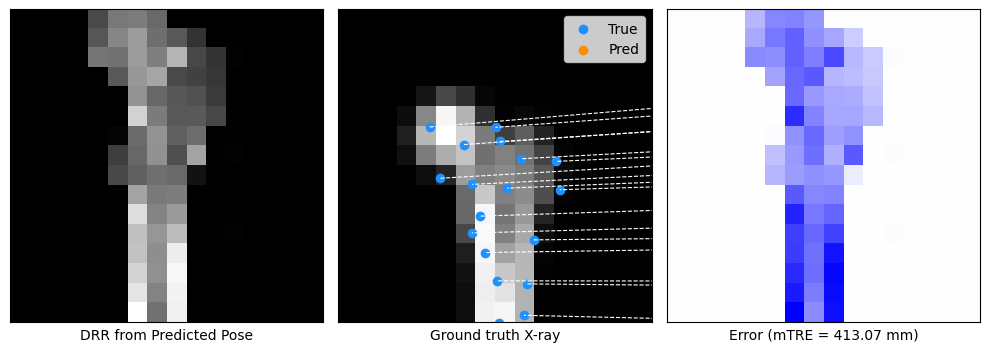

In [20]:
plot_registration(drr, fiducials, gt, init_pose, true_pose)

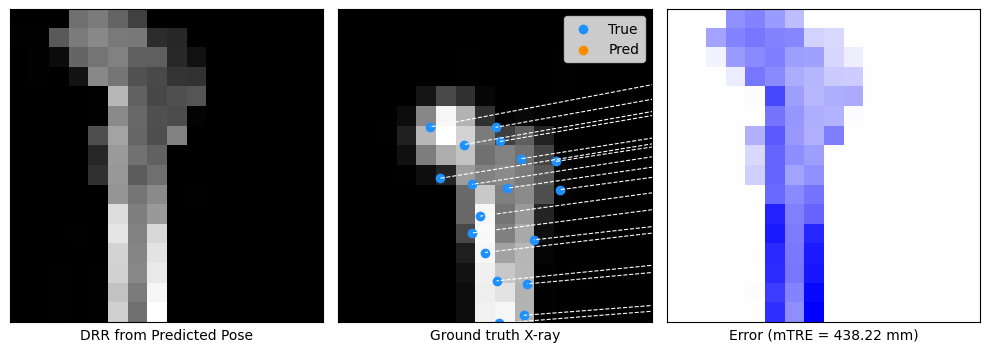

In [21]:
plot_registration(drr, fiducials, gt, final_pose, true_pose)